<a href="https://colab.research.google.com/github/Baisal89/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS6_113_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

X Variable: 
- predictor
- explanatory variable
- feature
- independent variable

Y Variable:
- predicted variable
- explained variable
- target
- dependent variable

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
import numpy as np
dir(np.random)

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(2500):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(7500):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users)

[User(purchased=False, time_on_site=140.696190984079, mobile=True), User(purchased=True, time_on_site=290.5042436658931, mobile=True), User(purchased=True, time_on_site=480.33982479767025, mobile=False), User(purchased=True, time_on_site=109.47769326345669, mobile=True), User(purchased=False, time_on_site=519.4606062850221, mobile=False), User(purchased=False, time_on_site=132.65077826542736, mobile=True), User(purchased=False, time_on_site=258.8839111427121, mobile=True), User(purchased=False, time_on_site=139.41029685707622, mobile=True), User(purchased=False, time_on_site=228.38042845997404, mobile=True), User(purchased=False, time_on_site=102.77443052715216, mobile=False), User(purchased=False, time_on_site=154.13684440785445, mobile=True), User(purchased=False, time_on_site=113.42117122637126, mobile=False), User(purchased=True, time_on_site=275.69502501983965, mobile=True), User(purchased=True, time_on_site=132.59296047130968, mobile=False), User(purchased=False, time_on_site=157

In [0]:
!pip freeze

In [6]:
!pip install pandas==0.23.4

In [7]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,140.696191,True
1,True,290.504244,True
2,True,480.339825,False
3,True,109.477693,True
4,False,519.460606,False


In [8]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.071479901897787,5.095326293625134,5.1044014793060235,5.1409345725792495,5.18674039029719,5.213116962885636,5.238113068221251,5.428401000301854,5.521688417046942,5.531749316631749,5.55978553711497,5.579765316572026,5.651893600372693,5.816751479452742,5.817479991615192,5.8224352142114375,5.878012143814951,5.907031325185695,5.9475064788867185,5.967570068795525,5.975952397803055,6.002671725773574,6.04057345922846,6.173782405386001,6.18351949108604,6.183759720635993,6.210600594567923,6.368525376019733,6.442852880156966,6.502128715628027,6.518682156877023,6.54361517763523,6.5731247991831205,6.5756037731077654,6.594293334804098,6.613317094679511,6.660779845709645,6.675188499782319,6.721946127439379,6.722745621761883,...,591.2187022085424,591.3531460414457,591.3551711662852,591.4645336995618,592.0462702046276,592.0977387546397,592.1681630697922,592.2202002451859,592.7784547908624,592.9271131851691,593.04583868661,593.258002866903,593.7484858957691,593.8709281933686,593.9711423349315,594.0694200577639,595.0229033981071,595.1403653330233,595.313010585661,595.3314662944039,595.8515703612002,596.095310944436,596.2605263490586,596.6479429451899,596.7215289191055,597.169060742267,597.2675340872034,597.7518390622332,597.8388528738355,597.8873186652285,597.9318685854049,597.9527529269238,597.9592763226127,598.0896927654434,598.1940388180153,598.2277680903491,598.4620635912394,599.1455173997377,599.3028482629171,599.4505748577166
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,1,0,1,1,1
True,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,0,0,0,0,1,0,1,0,1,0,0,0


In [9]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.477, 104.135]","(104.135, 203.198]","(203.198, 302.261]","(302.261, 401.324]","(401.324, 500.387]","(500.387, 599.451]"
purchased,,,,,,
False,1989,1905,1649,285,279,227
True,873,1008,1293,138,167,187


In [10]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.477, 104.135]","(104.135, 203.198]","(203.198, 302.261]","(302.261, 401.324]","(401.324, 500.387]","(500.387, 599.451]"
purchased,,,,,,
False,0.694969,0.653965,0.560503,0.673759,0.625561,0.548309
True,0.305031,0.346035,0.439497,0.326241,0.374439,0.451691


In [11]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.7056,0.609333
True,0.2944,0.390667


In [12]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')
ct

purchased               False        ...                      True 
time_on_site (4.477, 104.135]        ...         (500.387, 599.451]
mobile                               ...                           
False                0.137600        ...                     0.0748
True                 0.219333        ...                     0.0000

[2 rows x 12 columns]

In [13]:
type(ct)

pandas.core.frame.DataFrame

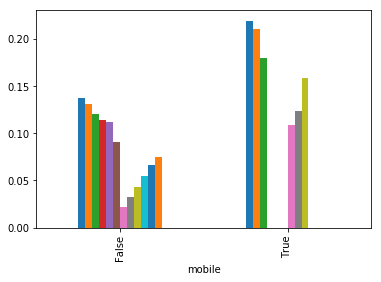

In [14]:
ct.plot(kind='bar', legend=False);

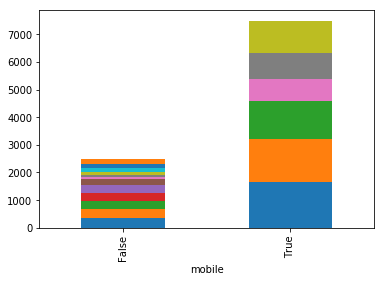

In [15]:
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins])

ct.plot(kind='bar', stacked=True, legend=False);

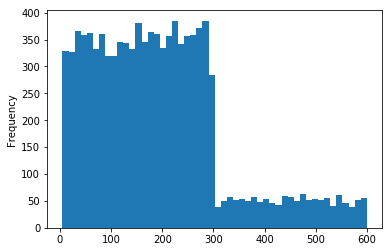

In [16]:
user_data['time_on_site'].plot.hist(bins=50);

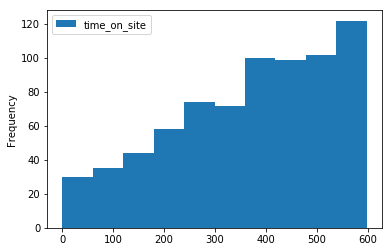

In [17]:
user_data[(user_data['mobile']==False) & (user_data['purchased']==True)].plot.hist()

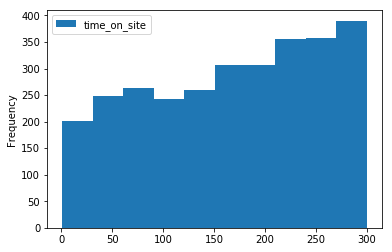

In [18]:
user_data[(user_data['mobile']==True) & (user_data['purchased']==True)].plot.hist()

In [19]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt

,purchased
time_on_site,
"(4.477, 104.135]",0.305031
"(104.135, 203.198]",0.346035
"(203.198, 302.261]",0.439497
"(302.261, 401.324]",0.326241
"(401.324, 500.387]",0.374439
"(500.387, 599.451]",0.451691


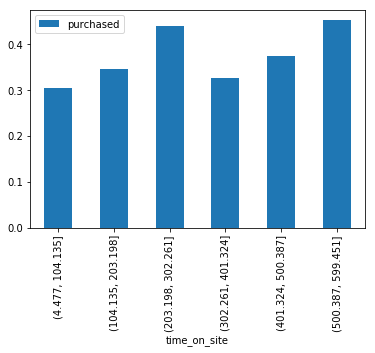

In [20]:
pt.plot.bar()

In [21]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.477, 104.135]    0.195011  0.359956  0.073370  0.279522
(104.135, 203.198]  0.185374  0.345295  0.111413  0.316041
(203.198, 302.261]  0.171202  0.294748  0.146739  0.404437
(302.261, 401.324]  0.161565  0.000000  0.187500  0.000000
(401.324, 500.387]  0.158163  0.000000  0.226902  0.000000
(500.387, 599.451]  0.128685  0.000000  0.254076  0.000000

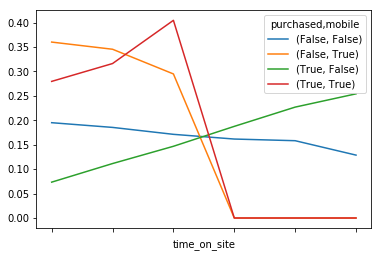

In [22]:
ct.plot();

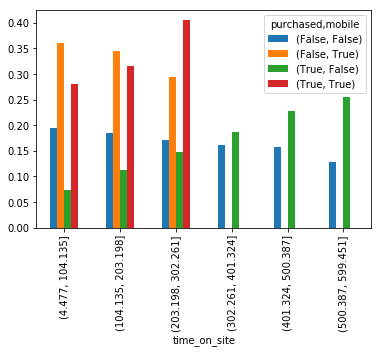

In [23]:
ct.plot(kind='bar');

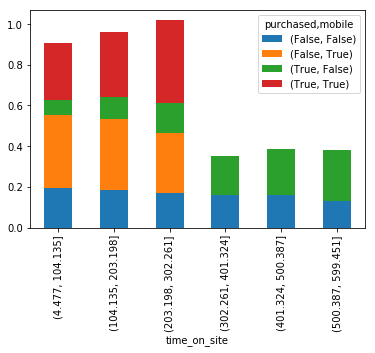

In [24]:
ct.plot(kind='bar', stacked=True);

In [25]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.477, 104.135]    0.195011  0.359956  0.073370  0.279522
(104.135, 203.198]  0.185374  0.345295  0.111413  0.316041
(203.198, 302.261]  0.171202  0.294748  0.146739  0.404437
(302.261, 401.324]  0.161565  0.000000  0.187500  0.000000
(401.324, 500.387]  0.158163  0.000000  0.226902  0.000000
(500.387, 599.451]  0.128685  0.000000  0.254076  0.000000

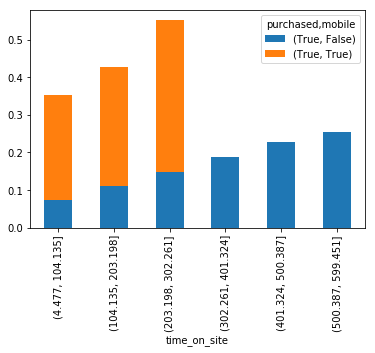

In [26]:
ct_sliced = ct.iloc[:, [2,3]]

ct_sliced.plot(kind='bar', stacked=True);

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself


In [0]:
import pandas as pd


In [0]:
df = pd.read_csv ('https://raw.githubusercontent.com/Baisal89/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')

In [3]:
!ls

sample_data


In [3]:
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [4]:
df.count()

Unnamed: 0       1200
age              1200
weight           1200
exercise_time    1200
dtype: int64

In [0]:
clean_data = df[['age', 'weight', 'exercise_time']]

In [8]:
clean_data.head(5)

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [9]:
df.columns

Index(['Unnamed: 0', 'age', 'weight', 'exercise_time'], dtype='object')

In [0]:
#inorder to crosstab all columns i had to bin each of them
time_bins = pd.cut(clean_data['exercise_time'], 10)  # 5 equal-sized bins
weight_bins = pd.cut(clean_data['weight'], 10)
age_bins = pd.cut(clean_data['age'], 10)
#pd.crosstab(clean_data['wright'],  time_bins)

In [0]:
#than i add them up and assigned
ct = pd.crosstab(age_bins, [weight_bins, time_bins],
                 rownames=['age'],
                 colnames=['weight', 'exercise_time'],
                 normalize='index')

In [13]:
ct.head()

weight         (99.854, 114.6]      ...       (231.4, 246.0]
exercise_time     (-0.3, 30.0]      ...         (30.0, 60.0]
age                                 ...                     
(17.938, 24.2]        0.000000      ...             0.007407
(24.2, 30.4]          0.000000      ...             0.000000
(30.4, 36.6]          0.007692      ...             0.000000
(36.6, 42.8]          0.008130      ...             0.000000
(42.8, 49.0]          0.008547      ...             0.000000

[5 rows x 76 columns]

In [0]:
import matplotlib.pyplot as plt


In [0]:
import seaborn as sns


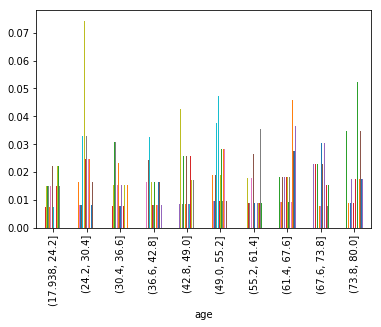

In [16]:
ct.plot(kind='bar', legend=False);


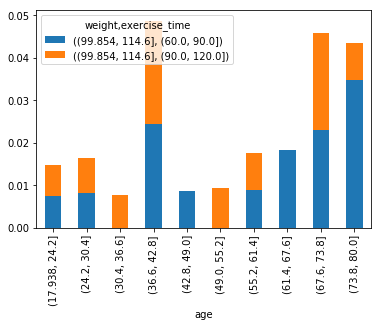

In [19]:
ct_sliced = ct.iloc[:, [2,3]]

ct_sliced.plot(kind='bar', stacked=True);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1. Variables are: age, weight, exercise_time
2. All variables are inteval level
3. Weight and exercise_time are real. False, I think is exercise_time and age

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)